In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [5]:
# Verileri çekmek
stocks = ['AMZN', 'GOOGL', 'TSLA', 'AAPL']
start_date = "2016-01-01"
end_date = "2024-11-01"

# Her hisse için kapanış fiyatlarını al
stock_data = {ticker: yf.download(ticker, start=start_date, end=end_date)['Close'] for ticker in stocks}

# Verileri birleştir
combined_data = pd.DataFrame(stock_data).dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
# Display the first few rows of the data
combined_data.head()

,AMZN,GOOGL,TSLA,AAPL
Date,,,,
2016-01-04,31.849501,37.972000,14.894000,26.337500
2016-01-05,31.689501,38.076500,14.895333,25.677500
2016-01-06,31.632500,37.966499,14.602667,25.174999
2016-01-07,30.396999,37.049999,14.376667,24.112499
2016-01-08,30.352501,36.545502,14.066667,24.240000


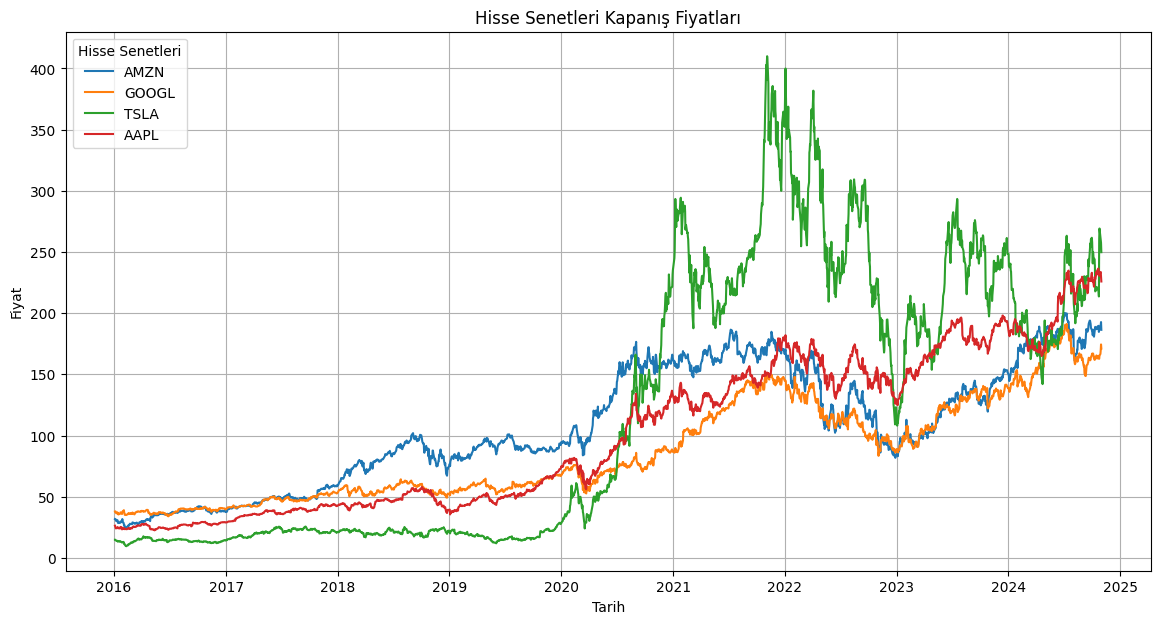

In [7]:
# Combined_data'yı görselleştirme
plt.figure(figsize=(14, 7))
for column in combined_data.columns:
    plt.plot(combined_data.index, combined_data[column], label=column)

plt.title("Hisse Senetleri Kapanış Fiyatları")
plt.xlabel("Tarih")
plt.ylabel("Fiyat")
plt.legend(title="Hisse Senetleri", loc='upper left')
plt.grid(True)
plt.show()

In [8]:
print("=============================================")
print("Data types of the columns in the data frame:", combined_data.dtypes) # Data types of the columns
print("=============================================")
print("Shape of the data frame:", combined_data.shape) # Shape of the data frame
print("=============================================")
print("Lenght of the data:", len(combined_data)) # Length of the data
print("=============================================")
print("Checking for missing values in the data:\n", combined_data.isnull().sum()) # Checking for missing values
print("=============================================")
combined_data.describe() # Summary statistics of the data

Data types of the columns in the data frame: AMZN     float64
GOOGL    float64
TSLA     float64
AAPL     float64
dtype: object
Shape of the data frame: (2223, 4)
Lenght of the data: 2223
Checking for missing values in the data:
 AMZN     0
GOOGL    0
TSLA     0
AAPL     0
dtype: int64


,AMZN,GOOGL,TSLA,AAPL
count,2223.000000,2223.000000,2223.000000,2223.000000
mean,107.908992,86.776827,122.395469,101.258318
std,48.543233,40.809819,111.072684,62.601656
min,24.103500,34.056999,9.578000,22.584999
25%,73.481251,52.864750,19.829667,42.772501
50%,98.699997,72.525002,59.960667,81.302498
75%,155.427002,122.266750,223.683334,155.830002
max,200.000000,191.179993,409.970001,236.479996


In [9]:
# Veriyi ölçeklendirme (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data)
scaled_df = pd.DataFrame(scaled_data, index=combined_data.index, columns=combined_data.columns)

# Veriyi %70 eğitim, %20 test, %10 doğrulama olarak bölme
train_size = int(len(scaled_df) * 0.7)
test_size = int(len(scaled_df) * 0.2)

train_data = scaled_df.iloc[:train_size]
test_data = scaled_df.iloc[train_size:train_size + test_size]
val_data = scaled_df.iloc[train_size + test_size:]

# Zaman serisi verisi hazırlama
window_size = 60  # Pencere boyutu: Son 60 gün
def create_time_series(data, window_size):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(x), np.array(y)

x_train, y_train = create_time_series(train_data.values, window_size)
x_test, y_test = create_time_series(test_data.values, window_size)
x_val, y_val = create_time_series(val_data.values, window_size)

In [10]:
# Modeli tanımlayın
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, x_train.shape[2])),
    Dropout(0.3),

    LSTM(100),
    Dropout(0.3),

    Dense(y_train.shape[1])  # Çıkış katmanı: tahmin yapılacak özellik sayısı
])

# ReduceLROnPlateau ve EarlyStopping callback'leri
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5) # Ogrenme hizi ni otomatik olarak azaltir
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli derleyin
model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğitin
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100, # Eğitim epoch sayısı
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/100


C:\Users\furka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0213 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0044 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0035 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0031 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0027 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0027 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0024 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0020 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0022 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 10/100
47/47 ━━━

In [15]:
model.summary() # Display the model summary

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,414 (1.41 MB)

 Trainable params: 122,804 (479.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 245,610 (959.42 KB)

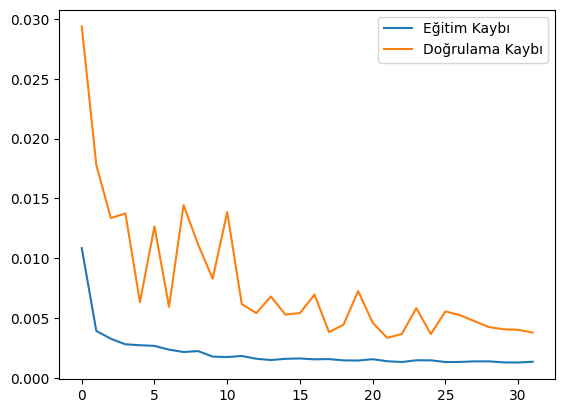

In [16]:
# Eğitim ve doğrulama kaybını görselleştirme

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.show()

In [18]:
# Test verisi üzerindeki performansı değerlendirme
y_pred = model.predict(x_test)

# Ölçek geri dönüşüm (inverse transform)
y_test_actual = scaler.inverse_transform(y_test)  # y_test'in gerçek değer ölçeğine dönüşümü
y_pred_actual = scaler.inverse_transform(y_pred)  # y_pred'in gerçek değer ölçeğine dönüşümü

mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = root_mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100


# Print the error metrics
print(f"=============================================")
print(f"Mean Squared Error: {mse:.2f}") # Mean Squared Error
print(f"Root Mean Squared Error: {rmse:.2f}") # Root Mean Squared Error
print(f"=============================================")
print(f"Mean Absolute Error: {mae:.2f} $ Gunluk Sapma Miktari") # Mean Absolute Error
print(f"=============================================")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%") # Mean Absolute Percentage Error
print(f"! A MAPE below 10-20% is generally considered good for financial predictions.")
print(f"=============================================")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Mean Squared Error: 118.59
Root Mean Squared Error: 9.59
Mean Absolute Error: 7.79 $ Gunluk Sapma Miktari
Mean Absolute Percentage Error (MAPE): 5.13%
! A MAPE below 10-20% is generally considered good for financial predictions.


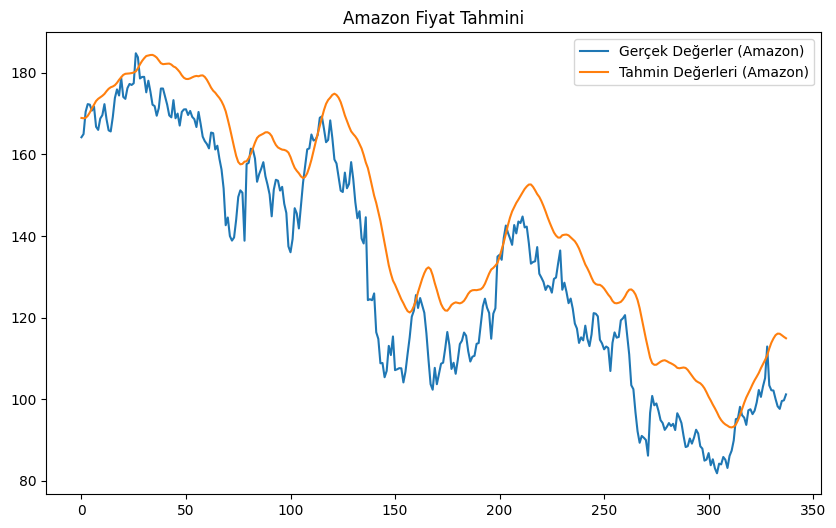

In [ ]:


# Tahminleri ve gerçek değerleri karşılaştır
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual[:, 0], label="Gerçek Değerler (Amazon)")
plt.plot(y_pred_actual[:, 0], label="Tahmin Değerleri (Amazon)")
plt.legend()
plt.title("Amazon Fiyat Tahmini")
plt.show()

In [19]:

# Gerçek ve tahmin edilen değişimleri sınıflandırma olarak kullanın
threshold = 0  # Fiyat değişimlerini sınıflandırmak için eşik
y_test_class = (y_test_actual[1:] > y_test_actual[:-1]).astype(int)
y_pred_class = (y_pred_actual[1:] > y_pred_actual[:-1]).astype(int)
# Performans metrikleri
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, average='weighted', zero_division=0)
recall = recall_score(y_test_class, y_pred_class, average='micro', zero_division=0)
f1 = f1_score(y_test_class, y_pred_class,average='micro', zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.15
Precision: 0.52
Recall: 0.56
F1 Score: 0.54
